# proyecto 

In [1]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic
from surprise import SVD
from surprise.model_selection import cross_validate
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlretrieve
from sklearn.metrics.pairwise import cosine_similarity


## carga de datos

In [3]:
urlretrieve("https://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
info = zip_ref.read('ml-100k/u.info')

users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols
movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

user_item_m = ratings.pivot('user_id','movie_id','rating')

## exploracion de datos

In [4]:
# se imprime el dataframe
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995


In [5]:
# se imprime el dataframe
user_item_m.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#Se buscan filas con puros nan, pues serian usuarios nuevos
user_item_m[user_item_m.isnull().all(axis=1)]

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,


In [7]:
#Se buscan columnas con puros nan, para ver peliculas sin ver
user_item_m[user_item_m.isnull().all(axis=0)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,


## infroamcion

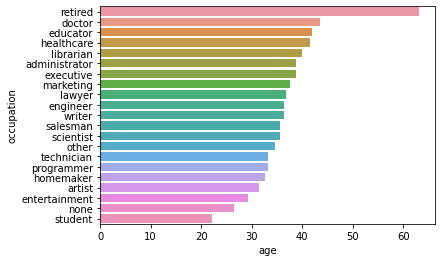

In [8]:
data = users.groupby("occupation")["age"].mean()
data = data.reset_index().sort_values("age", ascending=False)
sns.barplot(y="occupation",x="age", data=data)


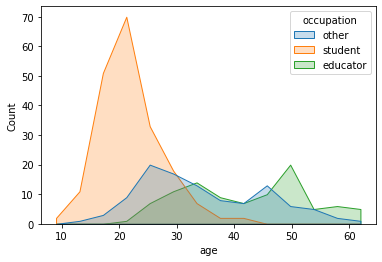

In [9]:
common_users = users[users["occupation"].isin(["student", "other","educator"])]
sns.histplot(common_users, x="age", hue="occupation", element="poly")

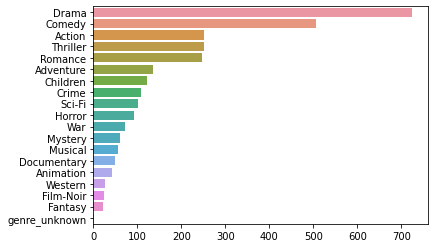

In [10]:
df=movies[genre_cols].sum().sort_values(ascending=False)
df
x = df.tolist()
y = df.index.tolist()
sns.barplot(x=x,y=y)


##svd

In [11]:
reader = Reader(rating_scale=(1, 5))
df = ratings[['user_id', 'movie_id', 'rating']]
df = df.rename(columns={"rating": "raw_ratings"})
data = Dataset.load_from_df(df[['user_id', 'movie_id', 'raw_ratings']], reader)

In [12]:
sim_options = {'name': 'pearson_baseline'}
algo = KNNBasic(sim_options=sim_options)

model = algo.fit(data.build_full_trainset())

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [13]:
algo =  SVD()

validation = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9397  0.9344  0.9234  0.9440  0.9337  0.9350  0.0069  
MAE (testset)     0.7406  0.7375  0.7305  0.7419  0.7349  0.7371  0.0041  
Fit time          12.87   12.07   9.38    5.42    5.41    9.03    3.17    
Test time         0.38    0.57    0.16    0.28    0.19    0.32    0.15    


In [14]:
model = algo.fit(data.build_full_trainset())

## definir modelo


In [15]:
def svd_recommender(user_id, umbral=4.5):

  nan_cols = [i for i in user_item_m.columns if np.isnan(user_item_m.loc[user_id][i])]

  candidatos =model.predict(uid=user_id, iid=1)

  rec_df = movies[movies["movie_id"].isin(candidatos)][["movie_id","title"]]
  return rec_df

## modelo en redes

In [16]:
df = ratings

user_ids = df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
num_users = len(ratings["user_id"].unique())

movie_ids = df["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
num_movies = len(ratings["movie_id"].unique())

df["user"] = df["user_id"].map(user2user_encoded)
df["movie"] = df["movie_id"].map(movie2movie_encoded)

In [17]:
min_rating = 1.0
max_rating = 5.0

x = df[["user", "movie"]].values

y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

idx = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:idx],
    x[idx:],
    y[:idx],
    y[idx:],
)

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class RecommenderNet(keras.Model):

    def __init__(self, num_users, num_movies, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        self.num_users = num_users
        self.num_movies = num_movies

        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1) # Bias

        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1) # Bias

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)

In [19]:
model = RecommenderNet(num_users, num_movies)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [20]:
batch_size = 64 
epochs = 5 

train_output = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1407/1407 [==============================] - 6s 3ms/step - loss: 0.6519 - val_loss: 0.6353
Epoch 2/5
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6271 - val_loss: 0.6260
Epoch 3/5
1407/1407 [==============================] - 5s 3ms/step - loss: 0.6191 - val_loss: 0.6215
Epoch 4/5
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6171 - val_loss: 0.6175
Epoch 5/5
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6167 - val_loss: 0.6163


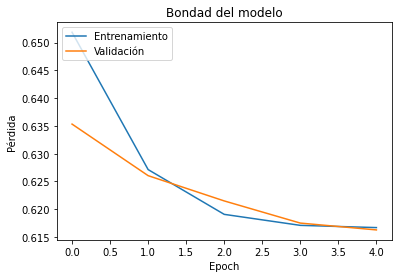

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_output.history["loss"])
plt.plot(train_output.history["val_loss"])
plt.title("Bondad del modelo")
plt.ylabel("Pérdida")
plt.xlabel("Epoch")
plt.legend(["Entrenamiento", "Validación"], loc="upper left")
plt.show()

In [22]:
def nn_recommender(user_id, num=10):

  seen_movies = ratings[ratings["user_id"] == user_id]

  not_seen = movies[~movies["movie_id"].isin(seen_movies["movie_id"].values)]["movie_id"].tolist()
  not_seen = list(set(not_seen).intersection(set(movie2movie_encoded.keys())))
  not_seen = [[movie2movie_encoded.get(x)] for x in not_seen]

  encoded_id = user2user_encoded.get(user_id)

  input_data  = np.hstack(([[encoded_id]] * len(not_seen), not_seen))
  pred_ratings = model.predict(input_data).flatten()

  top_rated = pred_ratings.argsort()[-num:][::-1]

  movie_id = [movie_encoded2movie.get(not_seen[x][0]) for x in top_rated]

  return movies[movies["movie_id"].isin(movie_id)]["title"]

In [23]:
nn_recommender(196)

49                     Star Wars (1977)
63     Shawshank Redemption, The (1994)
168          Wrong Trousers, The (1993)
171     Empire Strikes Back, The (1980)
173      Raiders of the Lost Ark (1981)
177                 12 Angry Men (1957)
312                      Titanic (1997)
317             Schindler's List (1993)
482                   Casablanca (1942)
602                  Rear Window (1954)
Name: title, dtype: object

## Recomendacion por popularidad para usuarios nuevos


In [24]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [25]:
titles = movies[['title', 'movie_id']]
df = pd.merge(ratings, titles, on='movie_id')
df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64

In [26]:
ratings_df = pd.DataFrame(df.groupby('movie_id')['rating'].count())
ratings_df

,rating
movie_id,
1,452
2,131
3,90
4,209
5,86
...,...
1678,1
1679,1
1680,1


In [27]:
ratings_df.rename(columns={'rating': 'num_rating'}, inplace=True)
ratings_df['mean_ratings'] = pd.DataFrame(df.groupby('movie_id')['rating'].mean())
ratings_df['score'] = ratings_df['mean_ratings'] * ratings_df['num_rating']
ratings_df.sort_values(by='score', ascending=False).head(10)

,num_rating,mean_ratings,score
movie_id,,,
50,583,4.358491,2541.0
100,508,4.155512,2111.0
181,507,4.007890,2032.0
258,509,3.803536,1936.0
174,420,4.252381,1786.0
127,413,4.283293,1769.0
286,481,3.656965,1759.0
1,452,3.878319,1753.0
98,390,4.289744,1673.0


In [28]:
def popularity_based_recommender(user_id:int):
  top_rated = ratings_df.sort_values(by='score', ascending=False).head(100)

  already_seen = ratings[ratings["user_id"] == user_id]["movie_id"]

  not_seen = top_rated.merge(already_seen.drop_duplicates(), on=['movie_id','movie_id'], how='left', indicator=True)
  return_df = not_seen[not_seen['_merge'] == 'left_only']["movie_id"]

  return pd.merge(return_df, titles, on='movie_id')["title"].head(10)

In [29]:
def favorite_movies(user_id:int, num=10):
  rated = ratings[ratings["user_id"] == user_id]
  rated_info = pd.merge(rated, titles, on='movie_id')[["movie_id","title","rating"]]
  return rated_info.sort_values(by='rating', ascending=False).head(num)

## Recomendaicon de items vistos 

In [30]:
data = movies[['title']+genre_cols].set_index('title')
cosine_sim = cosine_similarity(data)

In [31]:
sim_matrix = pd.DataFrame(cosine_sim)
sim_matrix.columns = movies['movie_id'].values
sim_matrix.index += 1
sim_matrix

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,1.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.57735,0.000000
2,0.000000,1.000000,0.577350,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.816497,0.000000,0.000000,0.000000,0.000000,0.000000,0.408248,0.000000,0.00000,0.000000
3,0.000000,0.577350,1.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107,0.000000,0.00000,0.000000
4,0.333333,0.333333,0.000000,1.000000,0.333333,0.577350,0.408248,0.666667,0.577350,0.408248,...,0.408248,0.577350,0.577350,0.577350,0.577350,0.577350,0.000000,0.408248,0.57735,0.577350
5,0.000000,0.333333,0.577350,0.333333,1.000000,0.577350,0.408248,0.333333,0.577350,0.408248,...,0.408248,0.577350,0.577350,0.577350,0.577350,0.577350,0.408248,0.408248,0.00000,0.577350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.000000,0.000000,0.000000,0.577350,0.577350,1.000000,0.707107,0.577350,1.000000,0.707107,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.707107,0.00000,1.000000
1679,0.000000,0.408248,0.707107,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.00000,0.000000
1680,0.000000,0.000000,0.000000,0.408248,0.408248,0.707107,0.500000,0.408248,0.707107,0.500000,...,0.000000,0.707107,0.707107,0.707107,0.707107,0.707107,0.500000,1.000000,0.00000,0.707107
1681,0.577350,0.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.577350,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000


In [32]:
def find_similar(movie_id):
  # Obtenemos las métricas para las peliculas
  m_list = sim_matrix.loc[movie_id].tolist()
  # Filtramos por aquellas simialres
  similar_movies = [i+1 for i,x in enumerate(m_list) if x >= 0.99]
  # Devolvemos los titulos
  return movies[movies["movie_id"].isin(similar_movies)][["title"] + genre_cols]

##Recomendadores basadas en contenido

In [33]:
def content_based_recommender(user_id, num=10):
   fav_movies = favorite_movies(user_id, 10)
   already_seen = ratings[ratings["user_id"] == user_id]["movie_id"]
   not_seen = movies.merge(already_seen.drop_duplicates(), on=['movie_id','movie_id'], how='left', indicator=True)
   not_seen_id = not_seen[not_seen['_merge'] == 'left_only']["movie_id"]
   value_matrix = sim_matrix[fav_movies["movie_id"].to_list()]
   movies_to_recommend = value_matrix.loc[not_seen_id.to_list()]
   movies_to_recommend['average'] = movies_to_recommend.mean(numeric_only=True, axis=1)
   chosen_movies = movies_to_recommend['average'].sort_values(ascending=False).head(num).reset_index()["index"].to_list()
   return titles[titles["movie_id"].isin(chosen_movies)]

##Sistema hibrido

NameError: ignored